# Veloce Reduction

#### Author: Sven Buder (ANU, sven.buder@anu.edu.au)

github repository: https://github.com/svenbuder/veloce_reduction

#### History:  
240222: created

In [294]:
try:
    %matplotlib inline
    %config InlineBackend.figure_format='retina'
except:
    pass

# General packages
import numpy as np
import sys
import glob
from pathlib import Path

# scipy
from scipy.ndimage.filters import convolve
from scipy.signal import find_peaks, find_peaks_cwt, correlate

# astropy
from astropy.table import Table,hstack,vstack
from astropy.io import fits
from astropy.coordinates import SkyCoord, EarthLocation
import astropy.units as u
SSO = EarthLocation.of_site('Siding Spring Observatory')

# matplotlib
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm, LinearSegmentedColormap
from matplotlib.backends.backend_pdf import PdfPages

In [258]:
def input_reduction_date(date = '240219'):
    # Identify if running in jupyter notebook or out of command line
    if sys.argv[1] == '-f':
        print('Warning! Running in jupyter notebook. Adjust the default date!')
    else:
        date = sys.argv[1]
    print('Running reduction script for '+date)
    
    months = ['jan','feb','mar','apr','may','jun','jul','aug','sep','oct','nov','dec']
    
    return(date, months[int(date[2:-2])-1])

In [259]:
def identify_calibration_and_science_runs(date):
    
    print('\n=============================================')
    print('\nIdentifying calibration and science runs now\n')

    raw_file_path = 'raw_data/'+date+'/'

    log_file_path = glob.glob(raw_file_path+'*.log')
    if len(log_file_path) == 0:
        raise ValueError('No Log file present')
    else:
        if len(log_file_path) > 1:
            print('More than 1 Log file present, continuing with '+log_file_path[0]+'\n')
        else:
            print('Found Log file '+log_file_path[0]+'\n')
        log_file_path = log_file_path[0]

        log_file = open(log_file_path, "r")
        log_file_text = log_file.read()
        log_file.close()
        log_file_text = log_file_text.split('\n')

    # Now go through the log_file_text and read out all important information

    # Collect information about runs from log file.
    # We classify calibration_runs and science_runs
    calibration_runs = dict()
    calibration_runs['FibTh_15.0'] = []
    calibration_runs['FibTh_60.0'] = []
    calibration_runs['FibTh_180.0'] = []
    calibration_runs['SimTh_15.0'] = []
    calibration_runs['SimTh_60.0'] = []
    calibration_runs['SimTh_180.0'] = []
    calibration_runs['SimLC'] = []
    calibration_runs['Flat_0.1'] = []
    calibration_runs['Flat_1.0'] = []
    calibration_runs['Flat_10.0'] = []
    calibration_runs['Flat_60.0'] = []
    calibration_runs['Bstar'] = []
    # 'Dark' to be added depending on exposure times

    science_runs = dict()

    for line in log_file_text:
        # split line to read out specific information
        line_split = line.split(' ')

    #     print(line)

        # Identify runs via their numeric value
        run = line[:4]
        if not run.isnumeric():
            pass
        else:

            ccd = line[6]
            run_object = line[8:25].strip()
            utc = line[25:33].strip()
            exposure_time = line[35:42].strip()
            snr_noise = line[42:48].strip()
            snr_photons = line[48:53].strip()
            seeing = line[55:59].strip()
            lc_status = line[60:62].strip()
            thxe_status = line[63:67].strip()
            read_noise = line[70:85].strip()
            airmass = line[87:91].strip()
            overscan = line[97:].split()[0]
            comments = line[98+len(overscan):]
            if len(comments) != 0:
                if run_object != 'FlatField-Quartz':
                    print('Warning for '+run_object+' (run '+run+'): '+comments)

            # Read in type of observation from CCD3 info (since Rosso should always be available)
            if ccd == '3':
                if run_object == 'SimLC':
                    calibration_runs['SimLC'].append(run)
                elif run_object == 'FlatField-Quartz':
                    calibration_runs['Flat_'+exposure_time].append(run)
                elif run_object == 'ARC-ThAr':
                    calibration_runs['FibTh_'+exposure_time].append(run)
                elif run_object == 'SimThLong':
                    calibration_runs['SimTh_'+exposure_time].append(run)
                elif run_object == 'SimTh':
                    calibration_runs['SimTh_'+exposure_time].append(run)
                elif run_object == 'Acquire':
                    pass
                elif run_object == 'DarkFrame':
                    if 'Dark_'+exposure_time in calibration_runs.keys():
                        calibration_runs['Dark_'+exposure_time].append(run)
                    else:
                        calibration_runs['Dark_'+exposure_time] = [run]
                elif run_object in ['56139','105435','127972']:
                    calibration_runs['Bstar'].append(run)            
                else:
                    if run_object in science_runs.keys():
                        science_runs[run_object].append(run)
                    else:
                        science_runs[run_object] = [run]
                        
    return(calibration_runs, science_runs)

In [306]:
def create_median_image_from_runs(runs, ccd):
    
    run_images = []

    for run in runs:
        run_fits = fits.open('raw_data/'+date+'/ccd_'+ccd+'/'+date[-2:]+month+ccd+run+'.fits')
        run_images.append(run_fits[0].data)
        run_fits.close()

    return(np.median(run_images,axis=0))

def create_master_calibration_frames():
    
    print('\n=============================================')
    print('Creating Median Images for calibrations')

    master_calibrations = dict()

    for calibration_type in list(calibration_runs.keys()):
        print('\n    -> Creating median image for '+calibration_type)

        # Prepare routine print of master-calibration images
        if diagnostic_plots:
            f, gs = plt.subplots(1,3,figsize=(11,3))

        for ccd in ['1','2','3']:

            master_calibrations['ccd_'+ccd+'_'+calibration_type] = create_median_image_from_runs(calibration_runs[calibration_type], ccd)

            if diagnostic_plots:
                ax = gs[int(ccd)-1]
                counts = master_calibrations['ccd_'+ccd+'_'+calibration_type].flatten()
                counts_percentile = np.percentile(counts,q=[1,50,99])
                s = ax.imshow(
                    master_calibrations['ccd_'+ccd+'_'+calibration_type],
                    vmin=counts_percentile[0],vmax=counts_percentile[-1],
                    cmap = 'OrRd_r'
                )
                plt.colorbar(s,ax=ax,extend='both')
                ax.set_title('CCD '+ccd+' '+calibration_type)

        if diagnostic_plots:
            plt.tight_layout()    
            Path('reduced_data/'+date+'/diagnostic').mkdir(parents=True, exist_ok=True)
            plt.savefig('reduced_data/'+date+'/diagnostic/calibration_type+'.pdf',bbox_inches='tight',dpi=200)
            # plt.show()
            plt.close()
            
    return(master_calibrations)

# Run through routine

Warning! Running in jupyter notebook. Adjust the default date!
Running reduction script for 240219

Will save diagnostic runs


Identifying calibration and science runs now

Found Log file raw_data/240219/240219-AAT-2023B-24.log

Warning for HIP71683 (run 0140): Rosso slightly saturated.
Warning for HIP71683 (run 0140): Rosso slightly saturated.
Warning for HIP71683 (run 0140): Rosso slightly saturated.

Creating Median Images for calibrations

    -> Creating median image for FibTh_15.0


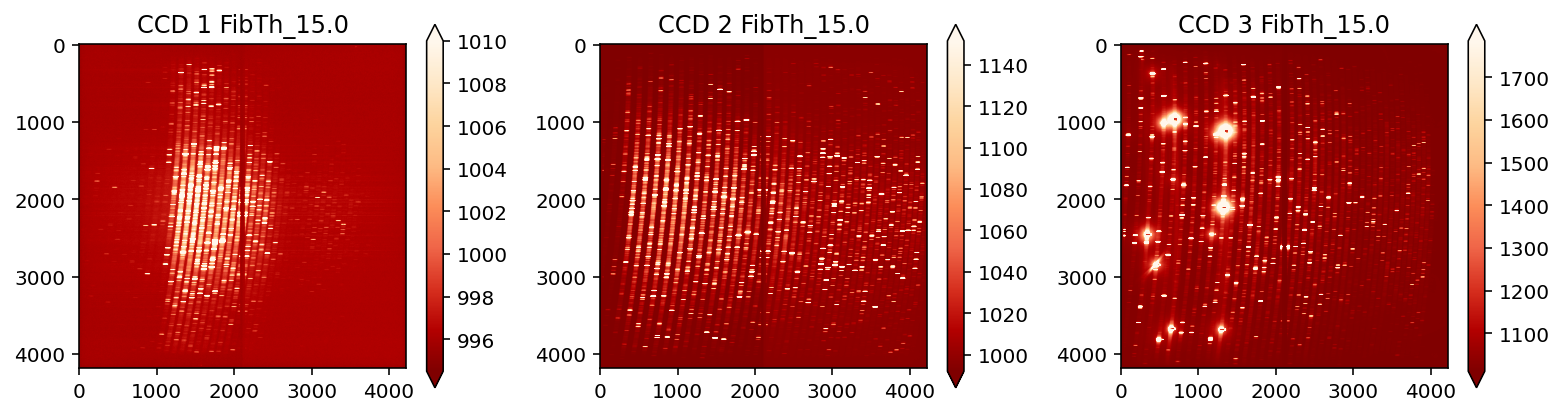


    -> Creating median image for FibTh_60.0


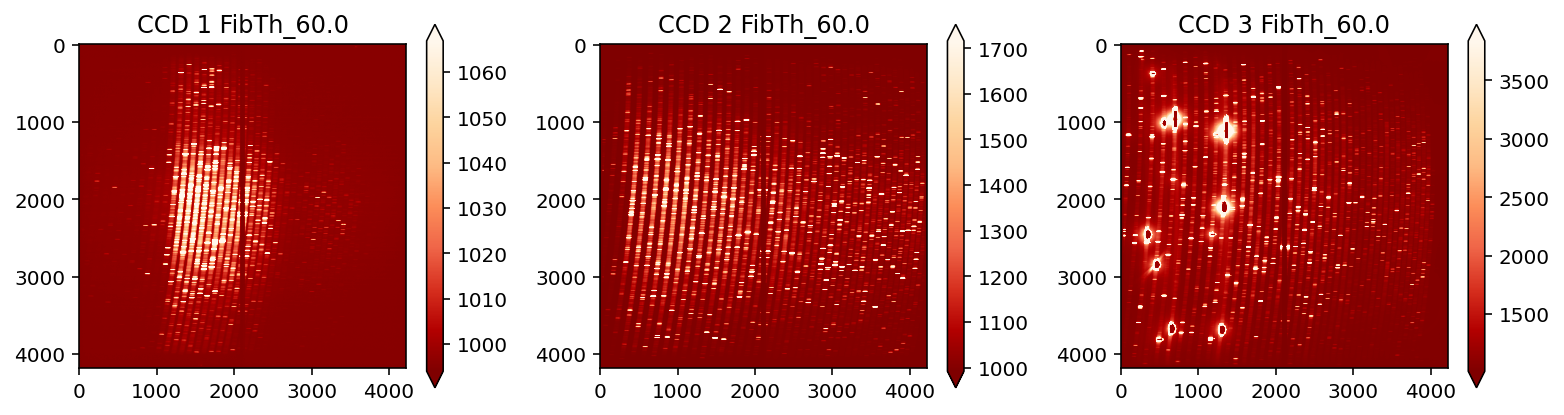


    -> Creating median image for FibTh_180.0


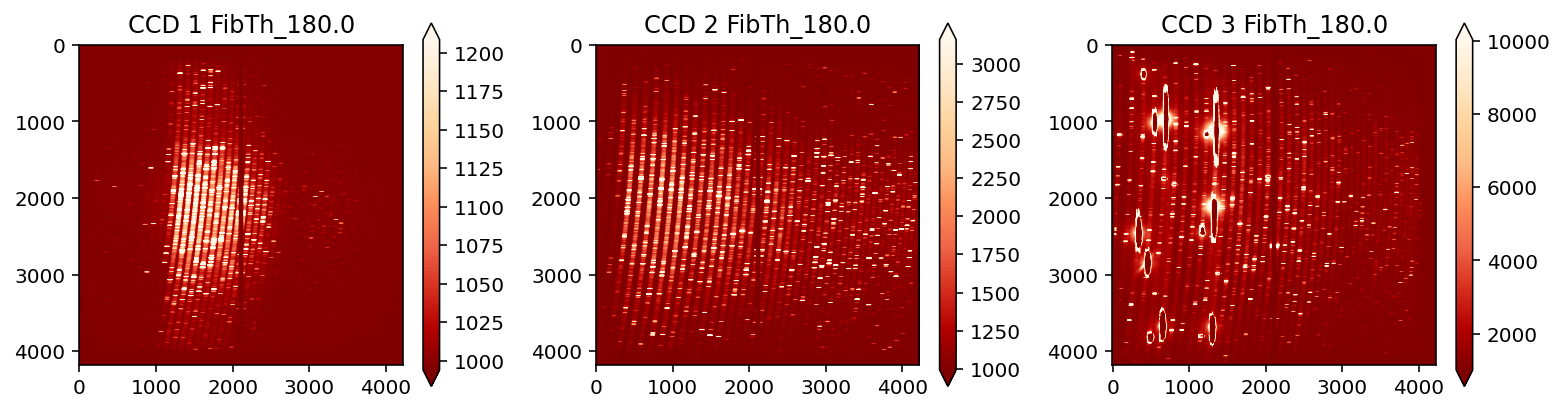


    -> Creating median image for SimTh_15.0


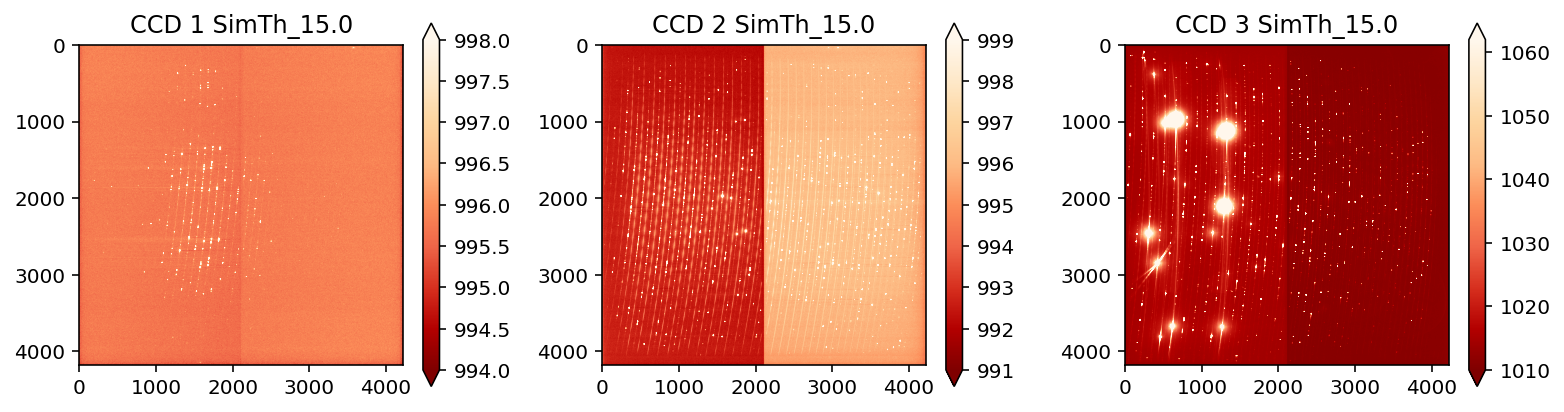


    -> Creating median image for SimTh_60.0


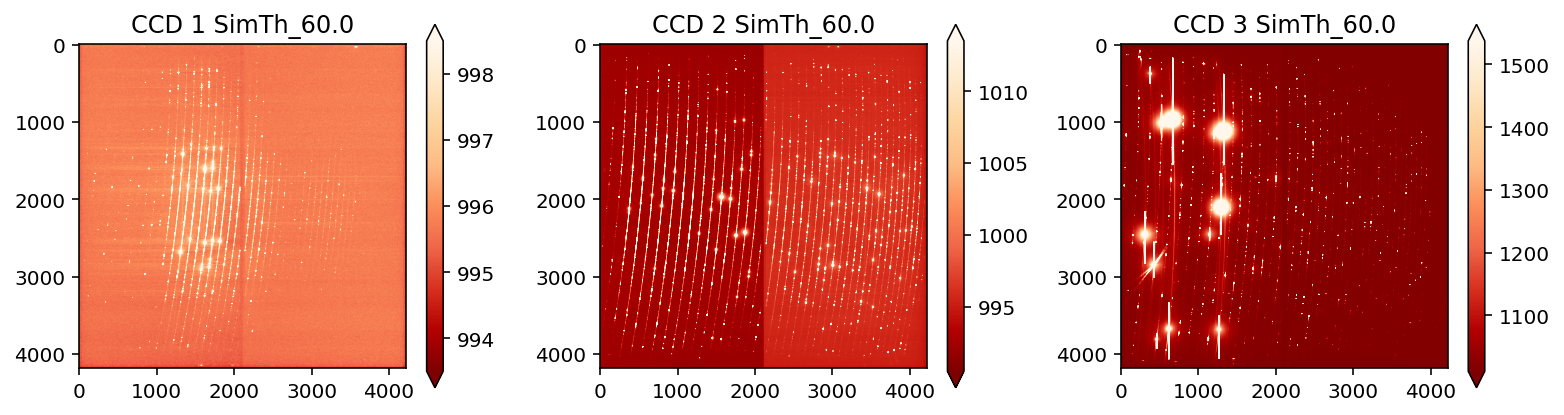


    -> Creating median image for SimTh_180.0


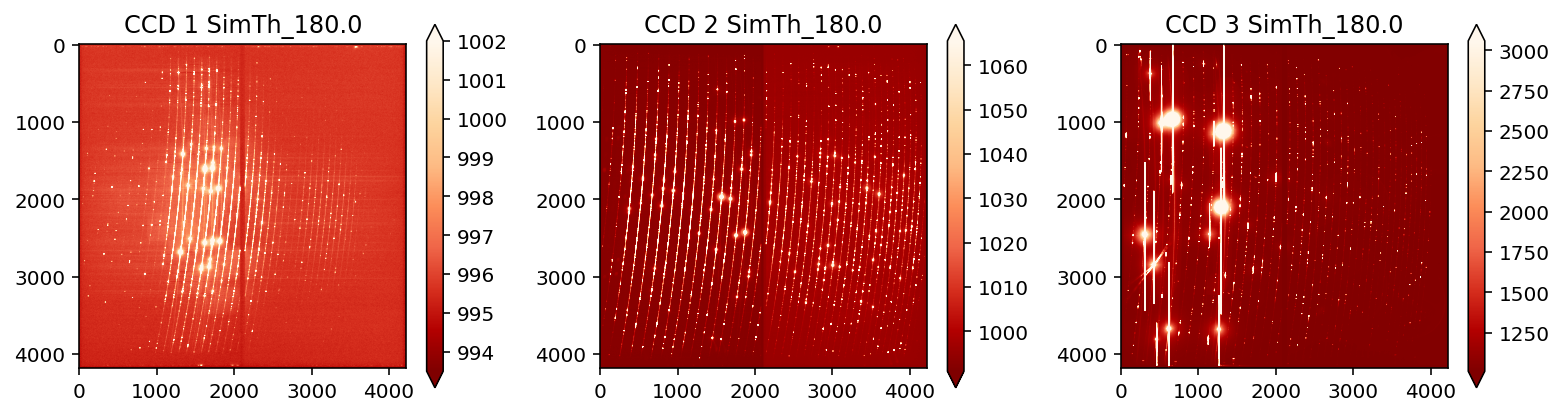


    -> Creating median image for SimLC


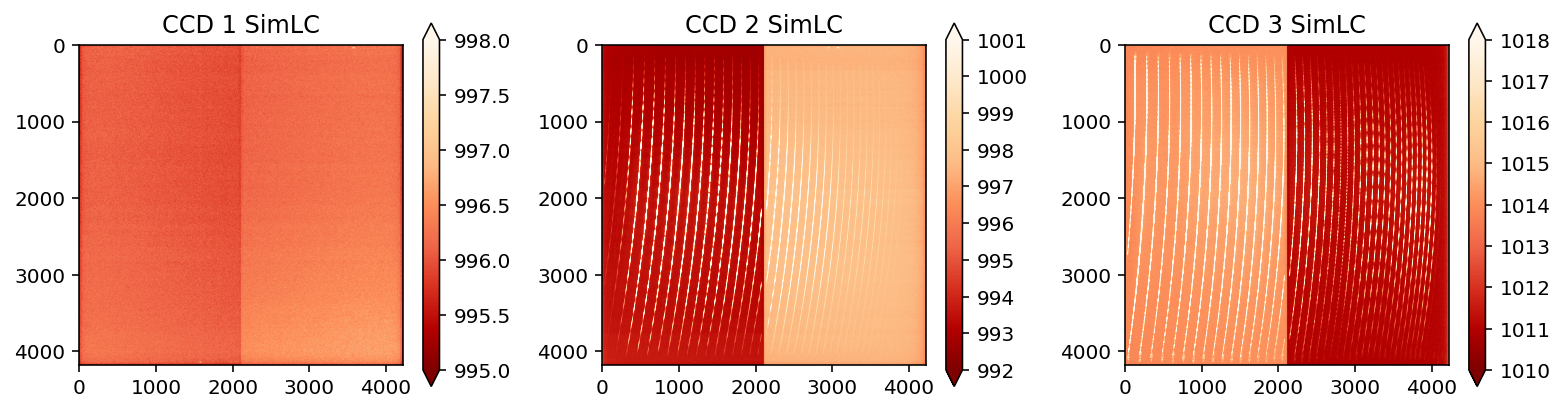


    -> Creating median image for Flat_0.1


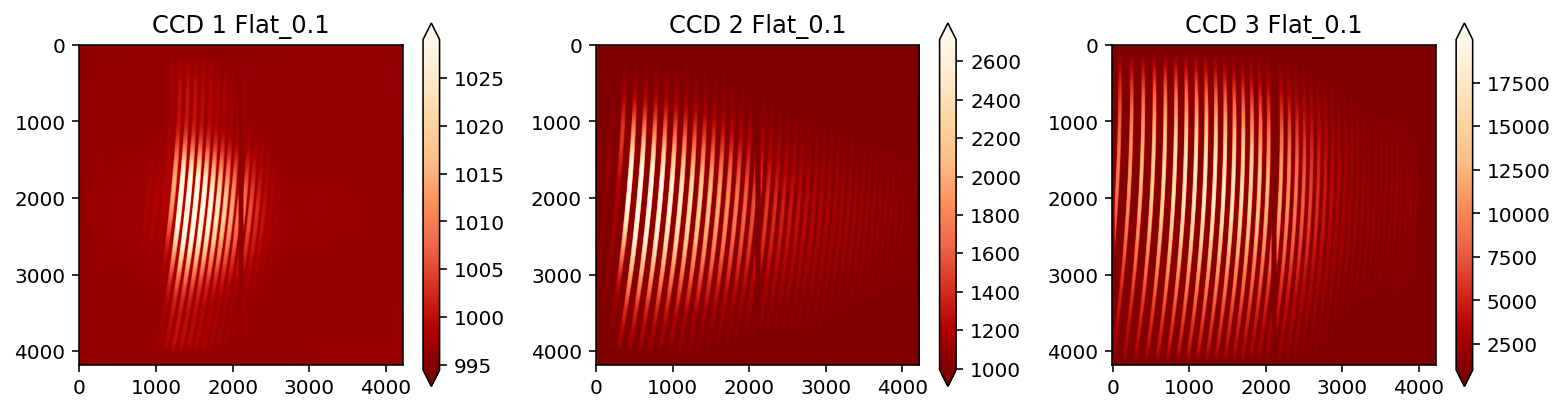


    -> Creating median image for Flat_1.0


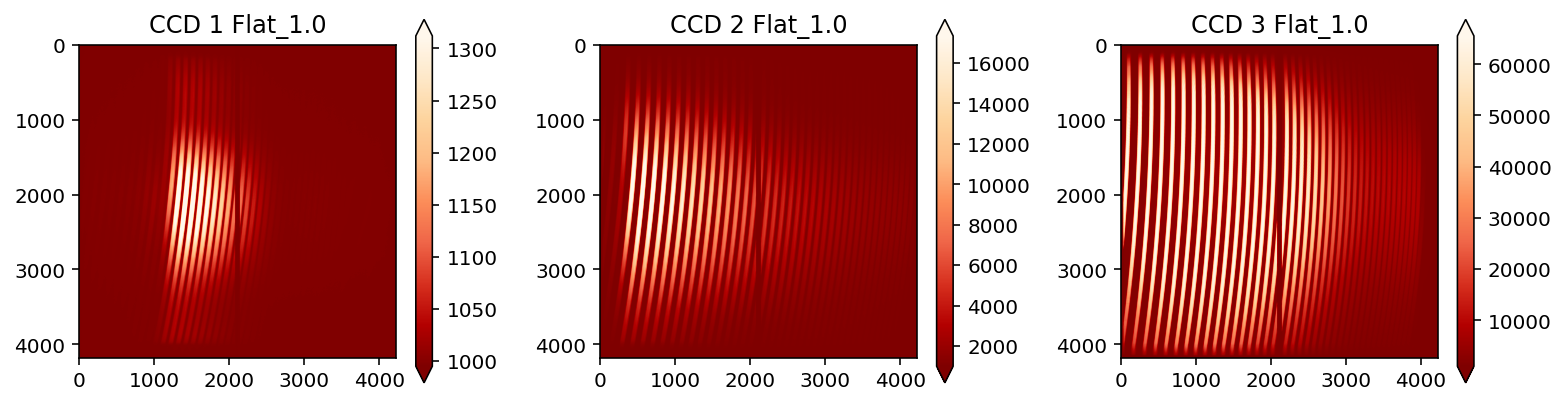


    -> Creating median image for Flat_10.0


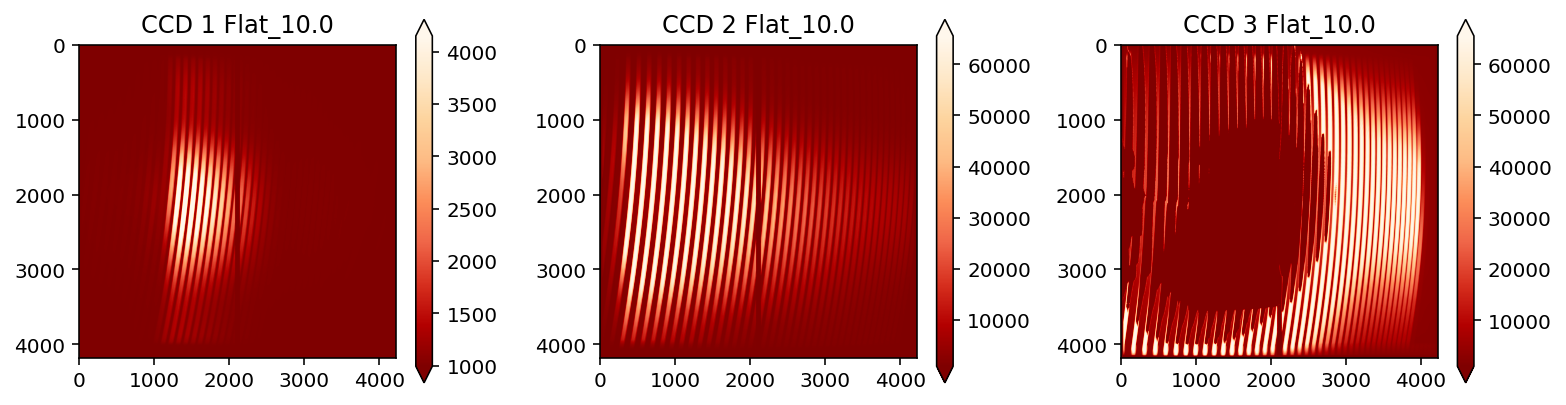


    -> Creating median image for Flat_60.0


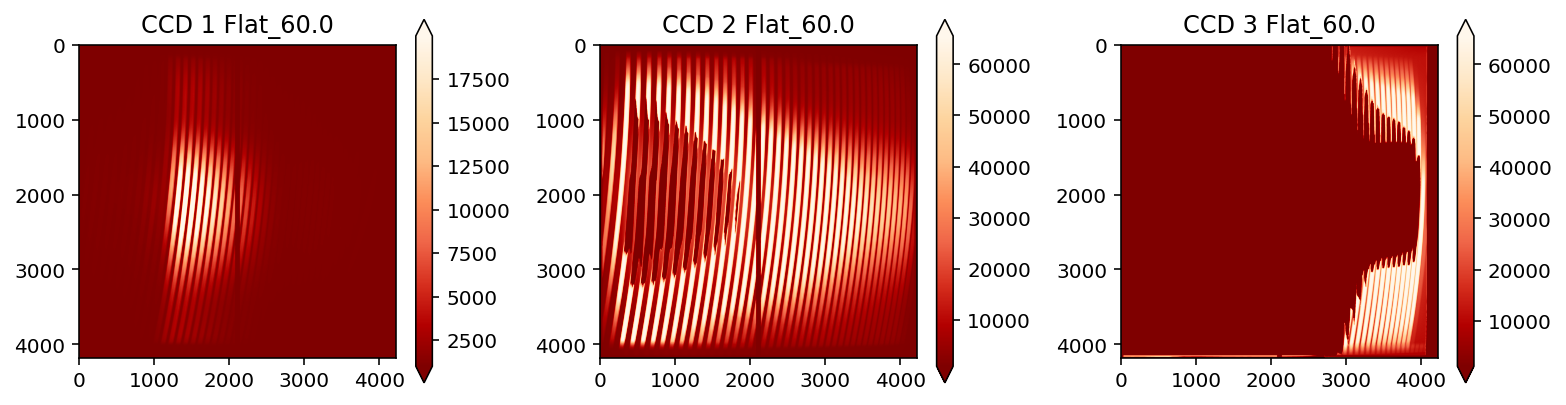


    -> Creating median image for Bstar


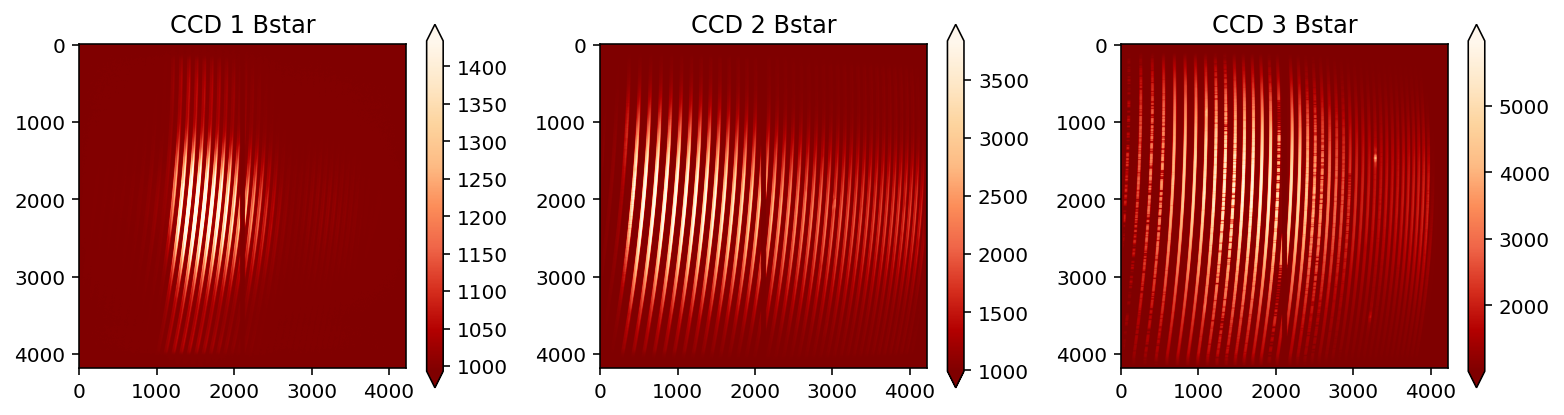


    -> Creating median image for Dark_1800.0


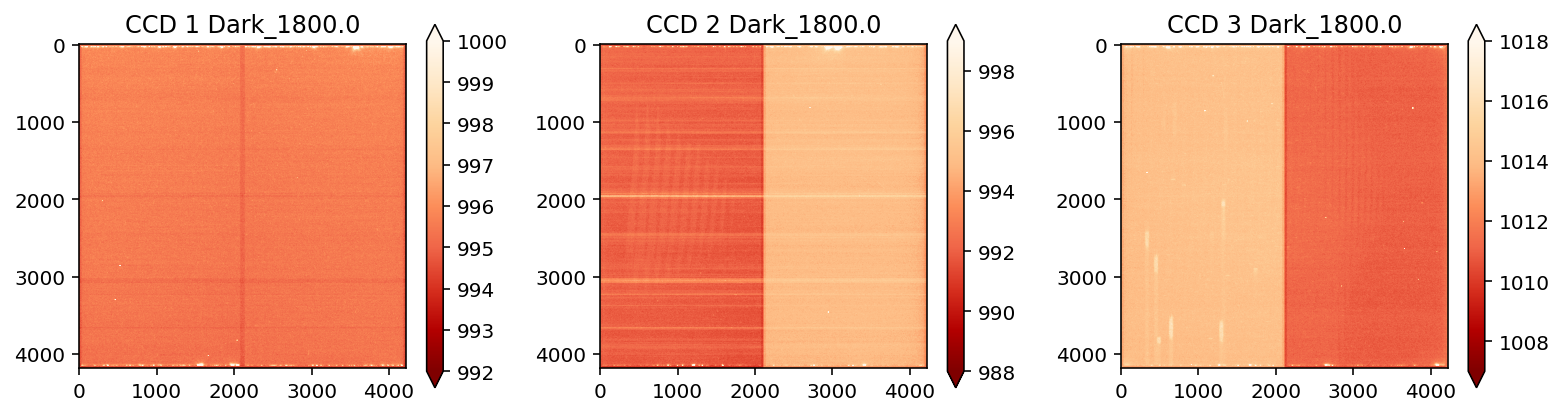


    -> Creating median image for Dark_900.0


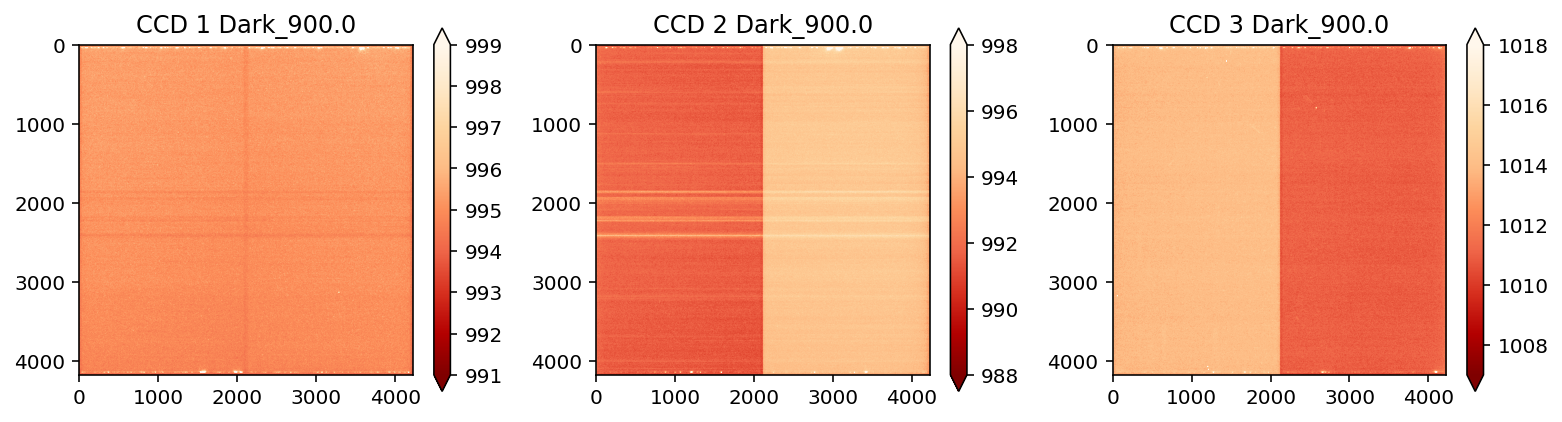


    -> Creating median image for Dark_300.0


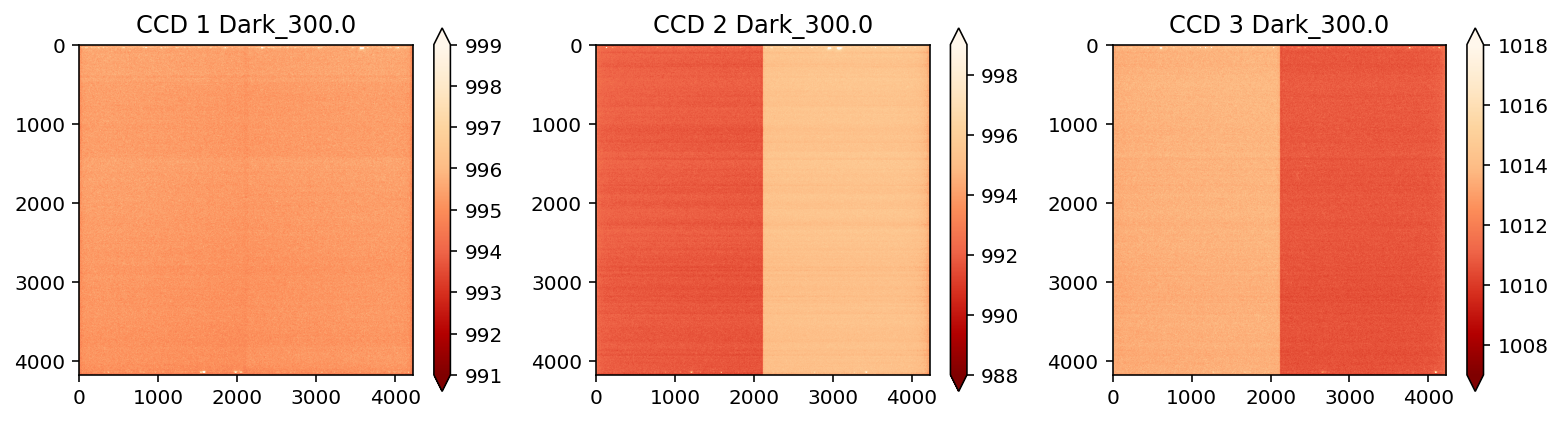

In [307]:
date, month = input_reduction_date()

diagnostic_plots=True
print('\nWill save diagnostic runs')

calibration_runs, science_runs = identify_calibration_and_science_runs(date)

master_calibrations = create_master_calibration_frames()